# Simulations for M5 single-strain model

In [1]:
from cobra.io import read_sbml_model

m5 = read_sbml_model("GEMs/M5_curated.xml")

## Static sim.

In [2]:
from utils import static_sim

In [14]:
medium = static_sim.get_specific_medium(m5, {"EX_xylan4_e": 0, "EX_xylan8_e": 1,})

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [4]:
sol_df = static_sim.get_productions(m5, medium, reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e"])

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


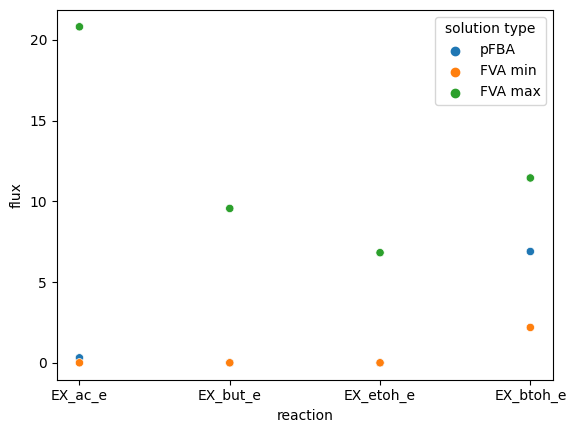

In [5]:
static_sim.plot_production_stats(sol_df)

In [6]:
from cobra.flux_analysis import pfba

with m5:
    m5.medium = medium
    summary = m5.summary()
    pfba_solution = pfba(m5)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [7]:
summary

Metabolite,Reaction,Flux,C-Number,C-Flux
ala__L_e,EX_ala__L_e,0.1,3,0.48%
arg__L_e,EX_arg__L_e,0.1,6,0.95%
asp__L_e,EX_asp__L_e,0.1,4,0.64%
ca2_e,EX_ca2_e,0.0009503,0,0.00%
cl_e,EX_cl_e,0.0009503,0,0.00%
cobalt2_e,EX_cobalt2_e,1.826E-05,0,0.00%
cu2_e,EX_cu2_e,0.0001295,0,0.00%
cys__L_e,EX_cys__L_e,0.01683,3,0.08%
dcyt_e,EX_dcyt_e,0.1,9,1.43%
fe2_e,EX_fe2_e,0.001226,0,0.00%


In [20]:
import escher
from escher import Builder

builder = Builder(map_json='new_map.json', model=m5, height=600)

In [21]:
builder.reaction_data = pfba_solution.fluxes

In [22]:
builder

Builder(height=600, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR141tipp': 0.0, '12DGR160tip…

In [12]:
m5.metabolites.btcoa_c.summary()

Percent,Flux,Reaction,Definition
100.00%,125.8,IBTMr,btcoa_c <=> ibcoa_c
Percent,Flux,Reaction,Definition
62.86%,-79.1,BTCOARx,btcoa_c + h_c + nadh_c --> btal_c + coa_c + nad_c
37.14%,-46.73,BUTCT,accoa_c + but_c <=> ac_c + btcoa_c


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

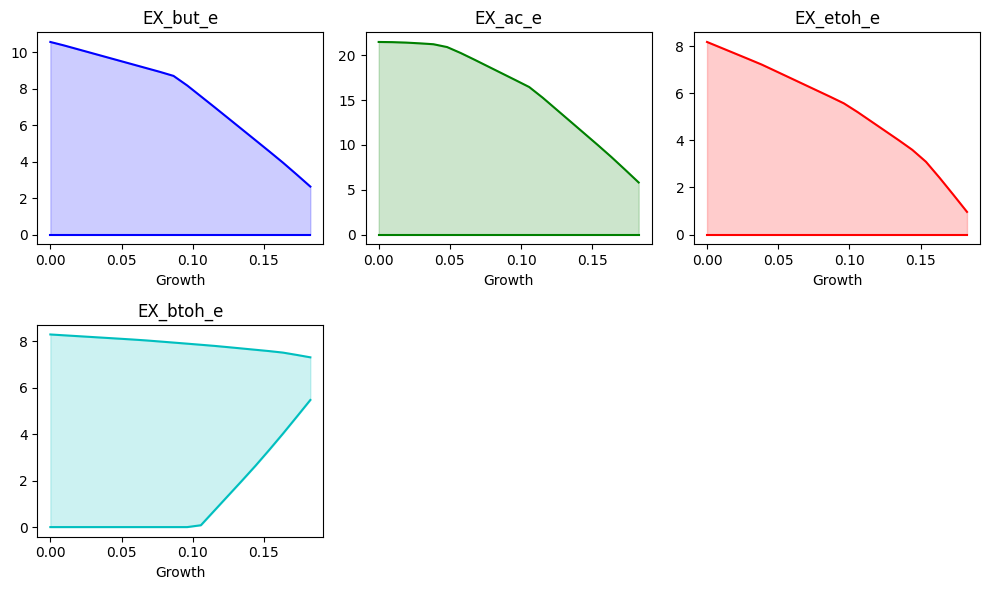

In [15]:
from utils import static_sim

medium = static_sim.get_specific_medium(m5, {"EX_xylan4_e": 0, "EX_xylan8_e": 1,})

prod_reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e"]

static_sim.plot_flux_envelopes(m5, medium=medium, reactions=prod_reactions)

## Dynamic sim.

In [9]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

m5_med = media_db[media_db["medium"] == "m5_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in m5_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}

# TODO: calculate xylan (60 g/L concentration) to an amount of moles that makes sense
#added_metabilotes["xylan4_e"] = 10
added_metabilotes["xylan8_e"] = 0.0025

In [10]:
from utils.comets_functions import single_strain

sim = single_strain(model=m5, medium=added_metabilotes, sim_time=40)


Running COMETS simulation ...
Done!


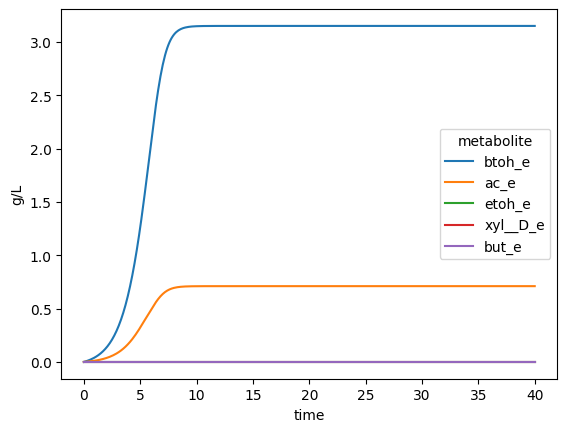

In [11]:
import seaborn as sns
from utils.comets_functions import plot_metabolites, plot_biomass, plot_reaction_flux

metabolites = ["xyl__D_e", "etoh_e", "but_e", "btoh_e", "ac_e"] #, "xylan4_e"]

plot_metabolites(sim, metabolites)

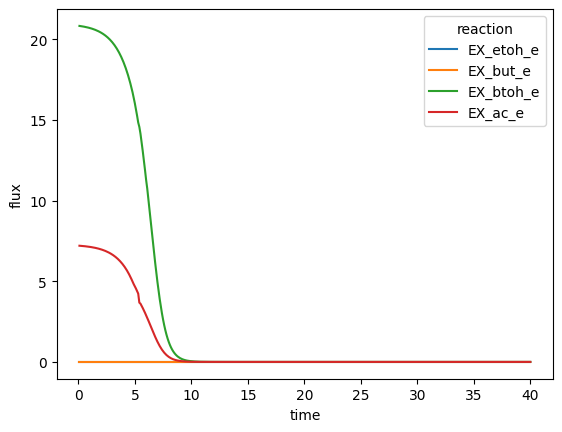

In [12]:
production_reactions = ["EX_etoh_e", "EX_but_e", "EX_btoh_e", "EX_ac_e"]

plot_reaction_flux(sim, production_reactions, "M5")

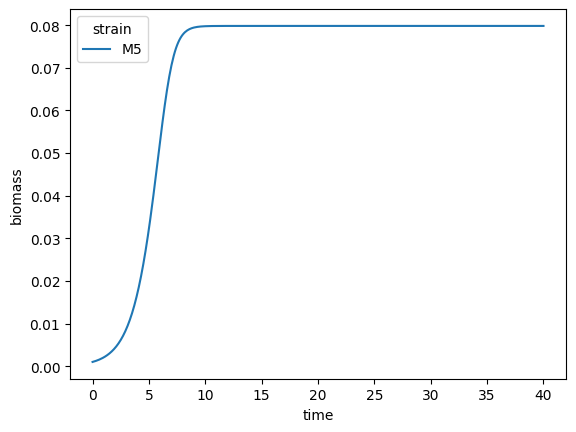

In [13]:
plot_biomass(sim)